<a href="https://colab.research.google.com/github/FrancoGalfrascoli/CSE---437-/blob/main/lab9_mountain_optimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Predictive Control (MPC) for the Mountain Car

## Exercise 1
In this exercise, you will implement **Model Predictive Control (MPC)** using a **random shooting method** to solve the **Mountain Car** problem.

You will complete the `mpc_action()` function, which chooses the best action sequence by simulating multiple random trajectories into the future and selecting the one with the lowest total cost.

---

## ⚙️ Environment Description
You are working with a **simplified Mountain Car** environment, where the goal is to reach and stay near the top of the right hill (`x ≈ 0.45`).

The car’s state is:
- `x` → position  
- `v` → velocity  

The control input is:
- `u` → engine thrust in the range `[-1, 1]`

The dynamics are defined as:
\[
v_{t+1} = v_t + 0.0015 u_t - 0.0025 \cos(3x_t)
\]
\[
x_{t+1} = x_t + v_{t+1}
\]

---

## 🚀 Task
Your task is to **implement mpc_action function for the MPC controller**.

At each step:
1. You will **sample random sequences of actions** for the next `H` steps.
2. You will **simulate** the effect of each sequence on the system using a provided dynamics model.
3. You will **compute the total cost** of each simulated trajectory.
4. You will **choose the best trajectory** (lowest cost) and apply its first action.

---

## ✅ Deliverables
* The completed mpc_action() function.
* A short report (few paragraphs) answering:
    * How does random shooting choose the best action?
    * How does changing H or N_seq affect the result?
    * Did your car reach and stay near the goal?

In [287]:
%matplotlib inline

# Setup environment and collect initial data

In [288]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500, render_mode="rgb_array")


### Dynamics
This is the underneath dynamics in the mountain car. For this exercise, we will use it, but for the following sessions, **we will learn it!**

In [289]:
def mountain_car_dynamics(p, v, a):
    v_next = v + 0.001 * a - 0.0025 * np.cos(3 * p)
    v_next = np.clip(v_next, -0.07, 0.07)
    p_next = p + v_next
    if p_next < -1.2:
        p_next, v_next = -1.2, 0.0
    return np.array([p_next, v_next])

# Test dynamics, at position p, and velocity v, predict the new location when the action a=1 is applied.
mountain_car_dynamics(p=-0.5, v=0, a=1.0)

array([-0.49917684,  0.00082316])

### Cost function

In [290]:
def cost_fn(state, a):
    x, v = state
    goal = 0.5
    target = goal - x

    # Encourage moving in the right direction and gaining kinetic energy
    cost = target**2 - 1000 * np.abs(v)
    return cost

## Roll out trajectories based on action sequences U

In [291]:
def roll_out_trajectory(s0, Ui, gamma=1.0):
    s = s0.copy()  # Initial state
    traj = [s0.copy()]  # Trajectory
    H = len(Ui)
    discount = 1.0

    total_cost = 0.0

    # For each time in the planning horizon
    for k in range(H):
        a = Ui[k]  # continuous action in [-1, 1]
        delta_m = np.zeros(2)

        # Predict Δx using both GPs (for Δp, Δv)
        s = mountain_car_dynamics(s[0], s[1], a)
        traj.append(s.copy())

        # Accumulate discounted cost
        total_cost += cost_fn(s, a) * discount
        discount *= gamma
    return np.array(traj), total_cost


def roll_out_n_trajectories(state, U):
    N_seq = len(U)
    J = np.zeros(N_seq)

    # Roll out trajectories and computer their cost
    all_traj = []
    for i in range(N_seq):
        traj, total_cost = roll_out_trajectory(state, U[i])

        J[i] = total_cost
        all_traj.append(np.array(traj))

    return all_traj, J

# Action squence
Ui = np.zeros(3)
traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)
traj

array([[-5.00000000e-01,  0.00000000e+00],
       [-5.00176843e-01, -1.76843004e-04],
       [-5.00529206e-01, -3.52362983e-04],
       [-5.01054453e-01, -5.25246664e-04]])

In [292]:
def plot_trajectories(state, best_traj):
    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(best_traj):
        plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.8, label=f"Traj {i+1}")
    plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
    plt.axvline(0.5, color='gray', ls='--', label='Goal position')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(f"Predicted Trajectories (Continuous MPC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Finding optimal action for MPC (Random Shooting)

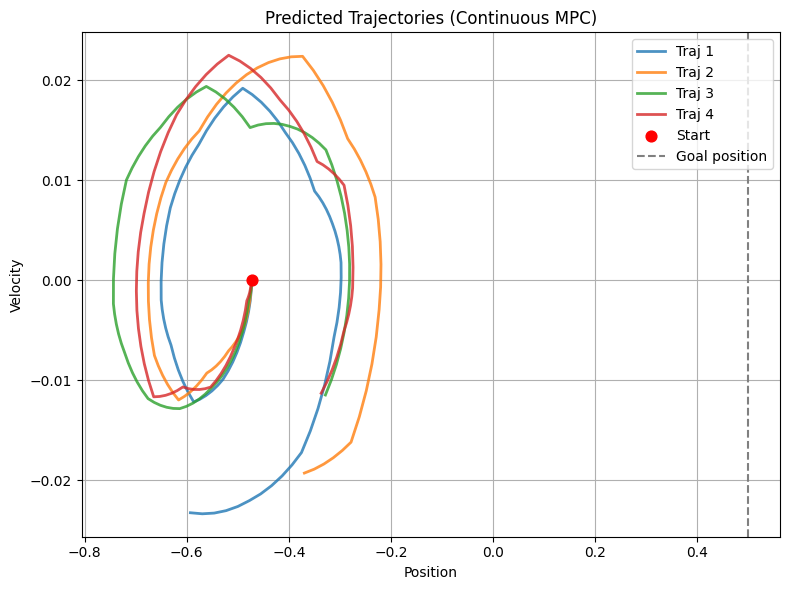

In [293]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
#  MPC (Random Shooting)
# --------------------------------------------------------------

def mpc_action(state, H=25, N_seq=200, plot=False, plot_best=10, repeat=5):
    """
    Random Shooting MPC for continuous actions in [-1, 1].
    Each GP predicts Δposition and Δvelocity given (pos, vel, action).
    """

    ########### TODO ####################
    # 1. Sample action sequences
    num_actions = np.ceil(H / repeat)
    U = np.random.uniform(-1, 1, (N_seq, int(num_actions)))
    U = np.repeat(U, repeats=repeat, axis=1)[:, :H]

    # 2. Roll out trajectories
    all_traj, J = roll_out_n_trajectories(state, U)

    # 3. Select top trajectories
    best_idx = np.argsort(J)[:plot_best]

    # Plot the best predicted trajectories
    if plot:
        best_traj = [all_traj[i] for i in best_idx]
        plot_trajectories(state, best_traj)

    # 4. Return the first action of the best sequence
    best_action = U[best_idx[0], 0]
    return best_action


obs, _ = env.reset(seed=0)
a = mpc_action(obs, H=80, N_seq=100, plot=True, plot_best=4)


In [294]:
# --------------------------------------------------------------
# Running in the gym environment
# --------------------------------------------------------------
H = 80        # MPC horizon
N_seq = 200   # Number of sampled action sequences
steps = 500   # Max episode length


obs, _ = env.reset()
returns = 0.0
a = 0.0       # initial action

trajectory = []

for t in range(steps):
    # --- 1. Compute optimal action via MPC ---
    a = mpc_action(obs, H=H, N_seq=N_seq)

    if t%10==0:
        print("t=",t, "state=", obs, "a=",a)

    # --- 2. Step environment ---
    next_obs, r, term, trunc, _ = env.step([a])  # continuous env expects array-like
    trajectory.append([obs,a])
    env.render()  # draw each step

    returns += r

    # --- 5. Prepare next step ---
    obs = next_obs
    if term or trunc:
        break

print(f"Episode return: {returns:.2f}")
env.close()


t= 0 state= [-0.5460427  0.       ] a= 0.8763767470764496
t= 10 state= [-0.47774065  0.01140309] a= 0.9593700609809659
t= 20 state= [-0.3476216   0.01208883] a= 0.9660030663096557
t= 30 state= [-2.6693910e-01  1.4343794e-04] a= -0.8701254211127885
t= 40 state= [-0.39637956 -0.02333947] a= -0.8563719003586852
t= 50 state= [-0.70240724 -0.03249251] a= -0.9569830197717066
t= 60 state= [-0.949965   -0.01423819] a= 0.24610623693532307
t= 70 state= [-0.9181788   0.01722074] a= 0.29933917633733276
t= 80 state= [-0.59442544  0.04213554] a= 0.21693719863580618
t= 90 state= [-0.16677248  0.03958287] a= 0.5256879593960915
t= 100 state= [0.09862563 0.0162297 ] a= -0.8624149194979149
t= 110 state= [ 0.08910866 -0.01350393] a= -0.8978894343066426
t= 120 state= [-0.20170665 -0.04229687] a= -0.7996202951014166
t= 130 state= [-0.7048751  -0.05220276] a= -0.704927160876615
t= 140 state= [-1.1457528  -0.03127549] a= 0.9371730068491202
t= 150 state= [-1.1283599   0.01716456] a= 0.8502584468273728
t= 160 s

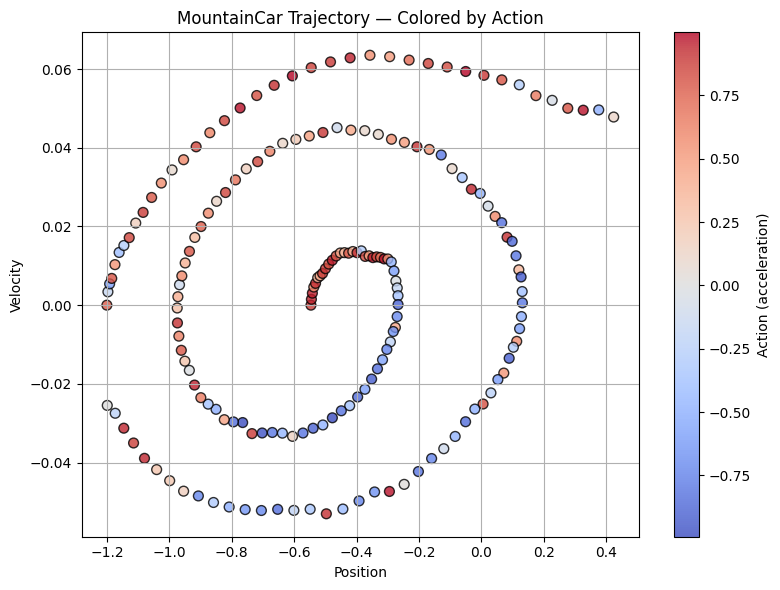

In [295]:
# trajectory is a list of [obs, a]
# each obs is [pos, vel]

def plot_trajectory(trajectory):
    positions, velocities, actions = [], [], []

    for entry in trajectory:
        obs, a = entry
        positions.append(obs[0])
        velocities.append(obs[1])
        actions.append(float(a))  # ensure scalar

    positions = np.array(positions)
    velocities = np.array(velocities)
    actions = np.array(actions)

    # --------------------------------------------------------------
    # Scatter plot: position vs velocity, colored by action
    # --------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(positions, velocities, c=actions,
                     cmap='coolwarm', s=50, edgecolor='k', alpha=0.8)

    cbar = plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("MountainCar Trajectory — Colored by Action")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_trajectory(trajectory)

* How does random shooting choose the best action?
* How does changing H or N_seq affect the result?
* Did your car reach and stay near the goal?

The algorightm runs mpc_action to generate list of actions. All this actions are eventually going to roll_out_trajectories where the car model is used to predict the future states of the car for each action. The cost is later computed for that state using cost_fn. This step is repeated for all the horizon lenght to obtain the total cost of the sequence of actions. This is done for all the sequences to obtain the total cost for each sequence. Finally, the best action is choosen selecting the first action of the sequence with the smallest total cost.

The value of H defines how long the horizon is, while N_seq defines the number of sequences used. Therefore, both having longer horizons and having more sequences will make the selection of the best action more accuarate. The first one because you can see 'more into the future', while the second one gives you more sequences to choose from.

In this problem, the cost function (cost = target**2 - 1000 * np.abs(v)) encourages the car to go as fast as possible with the term '- 1000 * np.abs(v)'. That is because bigger values of v will decrease the cost. Therefore, the car will arrive to the goal with the maximum possible velocity.

# 🧩 Exercise 2: Implement the MPPI Controller

In this exercise, you will complete the **`action()` method** of the `MPPIController` class.  
This method implements the **Model Predictive Path Integral (MPPI)** algorithm, which selects an optimal control action based on sampled action sequences and their simulated costs.

---

## ⚙️ MPPI Overview

Model Predictive Path Integral (MPPI) control is a **sampling-based model predictive controller**.  
It explores many possible future action sequences and evaluates them under a dynamics model.  
Unlike random shooting, MPPI adds **Gaussian noise around a mean sequence** and keeps track of a **persistent best sequence** that shifts at every step.

At each time step:

1. **Shift** the previous mean action sequence (`U_mean`) forward in time.  
   → This reuses information from the last solution.

2. **Sample** new action sequences by adding Gaussian noise around this mean.

3. **Roll out** each sequence using the system dynamics to compute its total cost.

4. Mean computation:
   * For undergraduate: **Select** the best trajectory (the one with the lowest cost) as the mean. (MPPI Simplified version)
   * For graduate: Compute **importance-weighted averages of control perturbations**, following the path-integral formulation of stochastic optimal control.

6. **Return** the first action of the best sequence to apply to the system.

---
# 🧩 Deliverables

* The completed action() method implementation.

* A short explanation (1–2 paragraphs) describing how your controller selects actions and how it differs from random shooting.

* Questions for Discussion

    * Why does MPPI reuse the previous mean sequence (U_mean)?

    * What would happen if we didn’t shift it each iteration?

    * How does the horizon H affect stability and responsiveness?

    * Compare MPPI to random shooting — what advantage does MPPI bring?


# MPPI

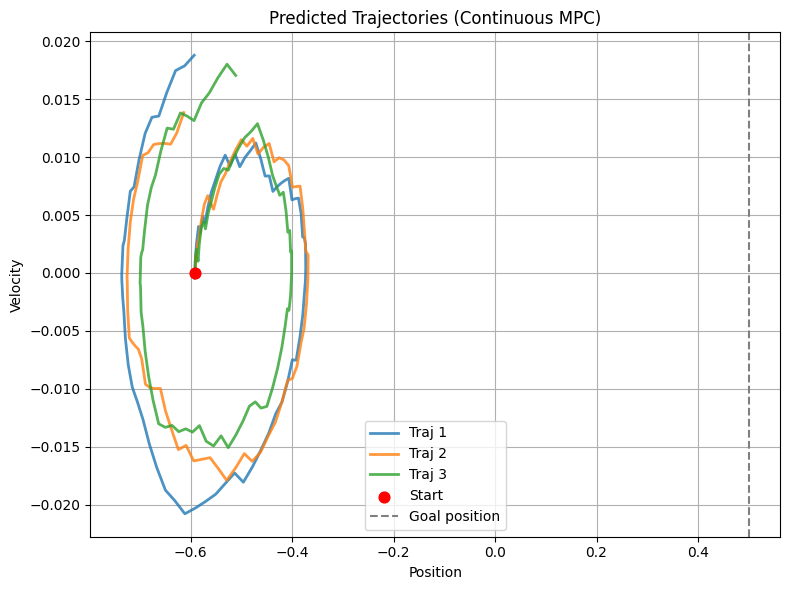

In [296]:
import numpy as np
import matplotlib.pyplot as plt

class MPPIController:
    def __init__(self, H=80, N_seq=150, λ=1.0, σ=0.3):
        """
        Model Predictive Path Integral Controller with persistent action sequence.
        Uses the best trajectory (lowest-cost) to update instead of weighted mean.
        """
        self.H = H
        self.N_seq = N_seq
        self.λ = λ
        self.σ = σ

        # Persistent mean sequence for warm-start
        self.U_mean = np.zeros(H)

    def action(self, state, plot=False, plot_best=3):
        H, N_seq, σ = self.H, self.N_seq, self.σ

        ######## TODO #############
        # 0 Shift previous mean sequence (reuse previous solution)
        if H > 1:
            self.U_mean[:-1] = self.U_mean[1:]
            self.U_mean[-1]  = self.U_mean[-2]  # hold last value

        # 1. Sample action sequences (Gaussian noise around previous U_mean)
        dU =  σ * np.random.randn(N_seq, H)
        U = self.U_mean[None, :] + dU
        U = np.clip(U, -1, 1)

        # 2. Roll out trajectories
        all_traj, J = roll_out_n_trajectories(state, U)

        # 3. Select the best trajectory (lowest cost)
        num = np.zeros(H)
        den = 1e-12
        J_min = J.min()
        for i in range(N_seq):
          num += np.exp(-(J[i]-J_min)/self.λ)*dU[i,:]
          den += np.exp(-(J[i]-J_min)/self.λ)

        self.U_mean += num/den
        self.U_mean = np.clip(self.U_mean, -1, 1)

        #  Optional: plot best trajectories
        if plot:
            best_k = np.argsort(J)[:plot_best]
            best_traj = [all_traj[i] for i in best_k]
            plot_trajectories(state, best_traj)

        # 4. Return the first action of the best sequence
        best_action = float(self.U_mean[0])
        return best_action

# Initialize controller once
mppi = MPPIController(H=80, N_seq=150, λ=1.0, σ=2.1)

obs, _ = env.reset()
a = mppi.action(obs, plot=True, plot_best=3)  # plot first iteration only


In [297]:
# Initialize controller once
mppi = MPPIController(H=30, N_seq=200, λ=.10, σ=.50)

obs, _ = env.reset(seed=0)
traj = []

for t in range(500):
    a = mppi.action(obs)  # plot first iteration only
    traj.append([obs, a])

    if t%10==0:
      print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])


    if term or trunc:
        break

print(f"Total time: {t:.0f}")


0 [-0.47260767  0.        ] -0.2032792834006596
10 [-0.5073135  -0.00742958] -1.0
20 [-0.6518688 -0.0186612] -1.0
30 [-0.8024309 -0.0060523] 0.6793144971557417
40 [-0.69980603  0.02320271] -0.1371999803843591
50 [-0.37450072  0.0376386 ] 1.0
60 [-0.02388792  0.02809007] -1.0
70 [ 0.05060866 -0.00986464] -0.641216086879568
80 [-0.23800573 -0.04490262] -0.9599674585014439
90 [-0.8145628  -0.06183671] 0.32786029756745405
100 [-1.1887621   0.00749607] 0.8834025718952929
110 [-0.9087938   0.04554681] 0.6585793053521524
120 [-0.29830265  0.06827468] 1.0
130 [0.34932122 0.06160988] 1.0
Total time: 131


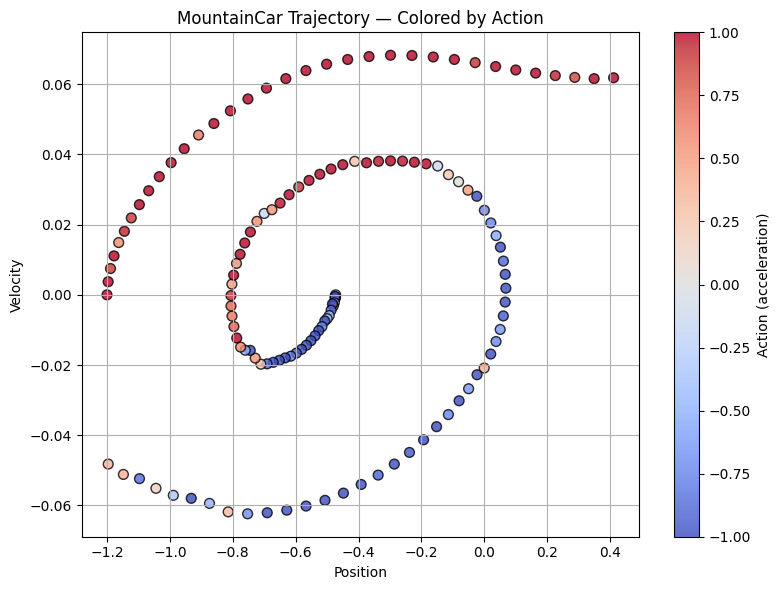

Energy 97.7077496410518


In [298]:
plot_trajectory(traj)

print("Energy", sum([a**2 for s,a in traj]))

    * Why does MPPI reuse the previous mean sequence (U_mean)?

    * What would happen if we didn’t shift it each iteration?

    * How does the horizon H affect stability and responsiveness?

    * Compare MPPI to random shooting — what advantage does MPPI bring?

  The MPPI algorithm uses Gaussian 'noise' on top of a sequence of actions U_mean. All this sequences are run and a total cost is obtained. Then, the vector U_mean is updated using a weight sum of the Gaussian noise using the total cost of each sequence.

  The MPPI resuses the previous mean sequence in order to have a reference to apply the noise. It takes advantage of the data that was computed during the previous step.

  I don't understand de question. If 'shift it each iteration' means to move the second action to the first position after each iteration is because the system evolved one step into the future. If the vector is not shifted, the first action would be for a time step that already passed.

  A longer horizon predicts longer into the future, using more information to make predictions. The system in that case is more stable. On the other hand, since a time step is updated more times before the system reaches it, that makes the responsiveness slower.

  I think that the main advantage that MPPI has is that is uses information from previous sequences, making the sampling more efficient.

# 🧩 Exercise 3: Reward Engineering — Stop at the Goal and Save Energy

In this exercise you will explore **reward shaping** and how it changes robot behavior.  
You will modify the Mountain Car reward so that the robot:
1. **Stops at the goal** rather than overshooting it.  
2. **Uses minimal control effort** (energy efficiency).

The goal is to understand how each term in a reward function influences motion and stability.

---

## ⚙️ Background
In reinforcement learning and model-based control, the reward (or cost) encodes *what* we want the agent to do.  
A poorly designed reward may lead to:
- Unstable or oscillatory behavior  
- Excessive control effort  
- Agents that reach the goal but never stop  

The standard Mountain Car reward only gives a terminal bonus for reaching the goal:
\[
r = 100 \, \mathbf{1}[x \ge 0.45] - 0.1u^2
\]
It encourages reaching the hilltop but does **not** reward *staying there* or *saving energy*.

---

## 🧩 Tasks

### a) Make the robot **stop at the goal**
You will modify the reward so that the agent receives high reward when it is **close to the goal** *and* has **small velocity**.

Implement a new reward function that encourages being near the goal position, and make the car stop once it arrives.  


Test this reward inside your MPC or MPPI loop.  
Observe whether the car reaches the top and remains there.

---

### b) Make the robot **save energy**
Design a second version of the reward that explicitly penalizes energy use more strongly. The energy is proportional to the square of the control input **a**.


Run simulations again and compare:
- Does the car reach the goal more slowly?  
- Does it stop more gently?  
- How much smaller are the average control inputs?

---

## Hint
Take into account that the weights help to scale the magnitude of the variables. For example,

---
# ✅ Deliverables

* Two implemented reward functions:

    * (a) Stop-at-goal

    * (b) Energy-saving

* Position, velocity, and control plots for both cases.

* A short report (≈ 1 paragraph per reward) answering:

    * How did each reward affect the trajectory?

    * Which terms were most influential?

    * Did the car stop smoothly at the goal?


In [309]:
def Stop_at_goal(state, a):
    x, v = state
    goal = 0.44
    target = goal - x

    # when the position is positive, the cost increases with velocity,
    # when x is negative, the car is encouraged to go fast
    cost = np.abs(target) + 45*x*np.abs(v)
    return cost

In [310]:
def roll_out_trajectory(s0, Ui, gamma=1.0):
    s = s0.copy()  # Initial state
    traj = [s0.copy()]  # Trajectory
    H = len(Ui)
    discount = 1.0

    total_cost = 0.0

    # For each time in the planning horizon
    for k in range(H):
        a = Ui[k]  # continuous action in [-1, 1]
        delta_m = np.zeros(2)

        # Predict Δx using both GPs (for Δp, Δv)
        s = mountain_car_dynamics(s[0], s[1], a)
        traj.append(s.copy())

        # Accumulate discounted cost
        total_cost += Stop_at_goal(s, a) * discount
        discount *= gamma
    return np.array(traj), total_cost


def roll_out_n_trajectories(state, U):
    N_seq = len(U)
    J = np.zeros(N_seq)

    # Roll out trajectories and computer their cost
    all_traj = []
    for i in range(N_seq):
        traj, total_cost = roll_out_trajectory(state, U[i])

        J[i] = total_cost
        all_traj.append(np.array(traj))

    return all_traj, J

# Action squence
Ui = np.zeros(3)
traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)
traj

array([[-5.00000000e-01,  0.00000000e+00],
       [-5.00176843e-01, -1.76843004e-04],
       [-5.00529206e-01, -3.52362983e-04],
       [-5.01054453e-01, -5.25246664e-04]])

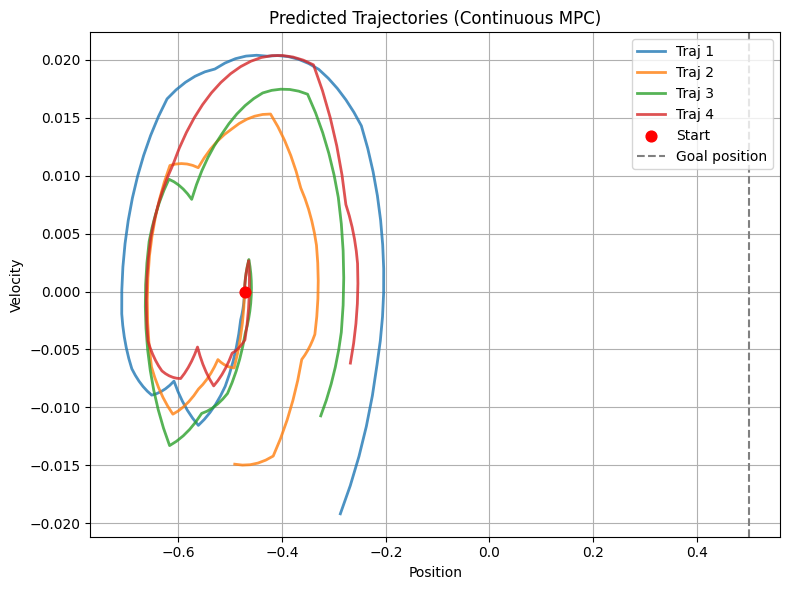

In [311]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
#  MPC (Random Shooting)
# --------------------------------------------------------------

def mpc_action(state, H=25, N_seq=200, plot=False, plot_best=10, repeat=5):
    """
    Random Shooting MPC for continuous actions in [-1, 1].
    Each GP predicts Δposition and Δvelocity given (pos, vel, action).
    """

    ########### TODO ####################
    # 1. Sample action sequences
    num_actions = np.ceil(H / repeat)
    U = np.random.uniform(-1, 1, (N_seq, int(num_actions)))
    U = np.repeat(U, repeats=repeat, axis=1)[:, :H]

    # 2. Roll out trajectories
    all_traj, J = roll_out_n_trajectories(state, U)

    # 3. Select top trajectories
    best_idx = np.argsort(J)[:plot_best]

    # Plot the best predicted trajectories
    if plot:
        best_traj = [all_traj[i] for i in best_idx]
        plot_trajectories(state, best_traj)

    # 4. Return the first action of the best sequence
    best_action = U[best_idx[0], 0]
    return best_action


obs, _ = env.reset(seed=0)
a = mpc_action(obs, H=80, N_seq=100, plot=True, plot_best=4)


In [312]:
# --------------------------------------------------------------
# Running in the gym environment
# --------------------------------------------------------------
H = 80        # MPC horizon
N_seq = 200   # Number of sampled action sequences
steps = 500   # Max episode length


obs, _ = env.reset()
returns = 0.0
a = 0.0       # initial action

trajectory = []

for t in range(steps):
    # --- 1. Compute optimal action via MPC ---
    a = mpc_action(obs, H=H, N_seq=N_seq)

    if t%10==0:
        print("t=",t, "state=", obs, "a=",a)

    # --- 2. Step environment ---
    next_obs, r, term, trunc, _ = env.step([a])  # continuous env expects array-like
    trajectory.append([obs,a])
    env.render()  # draw each step

    returns += r

    # --- 5. Prepare next step ---
    obs = next_obs
    if term or trunc:
        break

print(f"Episode return: {returns:.2f}")
env.close()


t= 0 state= [-0.5460427  0.       ] a= -0.645325695037237
t= 10 state= [-0.50725013  0.00878452] a= 0.8166090922121689
t= 20 state= [-0.37672147  0.01553631] a= 0.5530492675721976
t= 30 state= [-0.24089584  0.0110502 ] a= -0.6630293592145762
t= 40 state= [-0.274706   -0.01355568] a= -0.851006749517921
t= 50 state= [-0.54339975 -0.03545436] a= -0.708291329033403
t= 60 state= [-0.8926567  -0.02788338] a= 0.6747472682723419
t= 70 state= [-1.0084895   0.00177176] a= 0.03998486562392123
t= 80 state= [-0.83086514  0.02999696] a= 0.5403904169788663
t= 90 state= [-0.41294184  0.04687051] a= 0.25936934464274186
t= 100 state= [-0.00785813  0.03149714] a= -0.5993606416151309
t= 110 state= [0.17773192 0.0107536 ] a= 0.46173167150709427
t= 120 state= [ 0.1880015  -0.00895279] a= -0.11200516284775808
t= 130 state= [-0.05529422 -0.03955329] a= -0.4866321387726784
t= 140 state= [-0.5969319  -0.06197127] a= -0.3704539519717076
t= 150 state= [-1.1345931  -0.04122588] a= 0.9477905560203572
t= 160 state= 

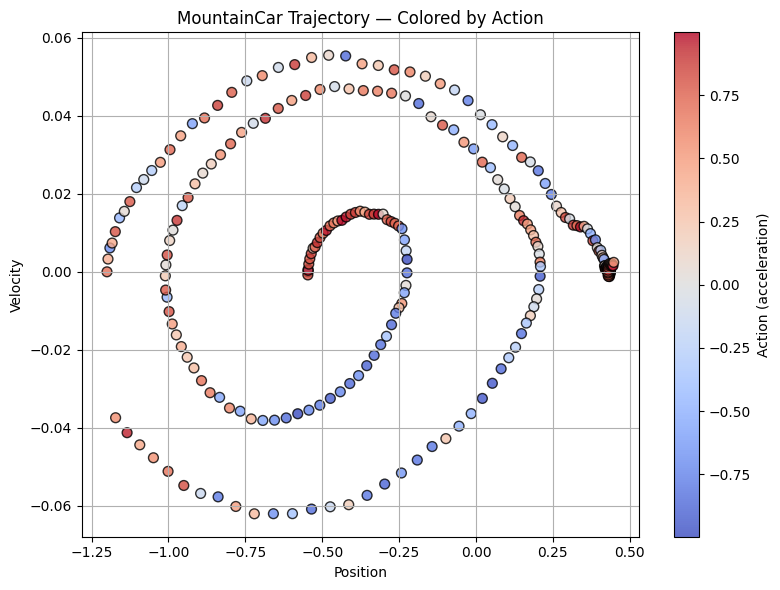

In [313]:
# trajectory is a list of [obs, a]
# each obs is [pos, vel]

def plot_trajectory(trajectory):
    positions, velocities, actions = [], [], []

    for entry in trajectory:
        obs, a = entry
        positions.append(obs[0])
        velocities.append(obs[1])
        actions.append(float(a))  # ensure scalar

    positions = np.array(positions)
    velocities = np.array(velocities)
    actions = np.array(actions)

    # --------------------------------------------------------------
    # Scatter plot: position vs velocity, colored by action
    # --------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(positions, velocities, c=actions,
                     cmap='coolwarm', s=50, edgecolor='k', alpha=0.8)

    cbar = plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("MountainCar Trajectory — Colored by Action")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_trajectory(trajectory)

**Energy Saving**

In [304]:
def energy_saving(state, a):
    x, v = state
    goal = 0.44
    target = goal - x

    # when the position is positive, the cost increases with velocity,
    # when x is negative, the car is encouraged to go fast
    cost = np.abs(target)*5 + np.abs(a)
    return cost

In [305]:
def roll_out_trajectory(s0, Ui, gamma=1.0):
    s = s0.copy()  # Initial state
    traj = [s0.copy()]  # Trajectory
    H = len(Ui)
    discount = 1.0

    total_cost = 0.0

    # For each time in the planning horizon
    for k in range(H):
        a = Ui[k]  # continuous action in [-1, 1]
        delta_m = np.zeros(2)

        # Predict Δx using both GPs (for Δp, Δv)
        s = mountain_car_dynamics(s[0], s[1], a)
        traj.append(s.copy())

        # Accumulate discounted cost
        total_cost += energy_saving(s, a) * discount
        discount *= gamma
    return np.array(traj), total_cost


def roll_out_n_trajectories(state, U):
    N_seq = len(U)
    J = np.zeros(N_seq)

    # Roll out trajectories and computer their cost
    all_traj = []
    for i in range(N_seq):
        traj, total_cost = roll_out_trajectory(state, U[i])

        J[i] = total_cost
        all_traj.append(np.array(traj))

    return all_traj, J

# Action squence
Ui = np.zeros(3)
traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)
traj

array([[-5.00000000e-01,  0.00000000e+00],
       [-5.00176843e-01, -1.76843004e-04],
       [-5.00529206e-01, -3.52362983e-04],
       [-5.01054453e-01, -5.25246664e-04]])

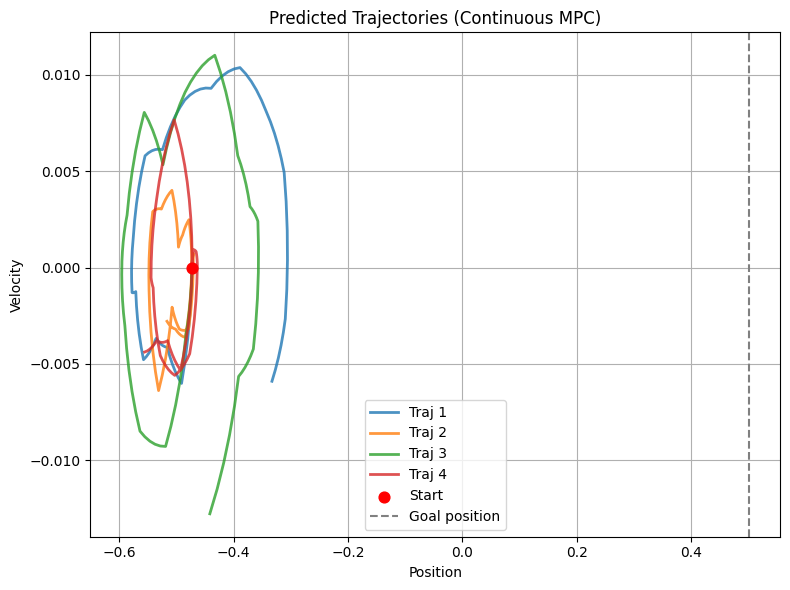

In [306]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
#  MPC (Random Shooting)
# --------------------------------------------------------------

def mpc_action(state, H=25, N_seq=200, plot=False, plot_best=10, repeat=5):
    """
    Random Shooting MPC for continuous actions in [-1, 1].
    Each GP predicts Δposition and Δvelocity given (pos, vel, action).
    """

    ########### TODO ####################
    # 1. Sample action sequences
    num_actions = np.ceil(H / repeat)
    U = np.random.uniform(-1, 1, (N_seq, int(num_actions)))
    U = np.repeat(U, repeats=repeat, axis=1)[:, :H]

    # 2. Roll out trajectories
    all_traj, J = roll_out_n_trajectories(state, U)

    # 3. Select top trajectories
    best_idx = np.argsort(J)[:plot_best]

    # Plot the best predicted trajectories
    if plot:
        best_traj = [all_traj[i] for i in best_idx]
        plot_trajectories(state, best_traj)

    # 4. Return the first action of the best sequence
    best_action = U[best_idx[0], 0]
    return best_action


obs, _ = env.reset(seed=0)
a = mpc_action(obs, H=80, N_seq=100, plot=True, plot_best=4)


In [307]:
# --------------------------------------------------------------
# Running in the gym environment
# --------------------------------------------------------------
H = 80        # MPC horizon
N_seq = 200   # Number of sampled action sequences
steps = 500   # Max episode length


obs, _ = env.reset()
returns = 0.0
a = 0.0       # initial action

trajectory = []

for t in range(steps):
    # --- 1. Compute optimal action via MPC ---
    a = mpc_action(obs, H=H, N_seq=N_seq)

    if t%10==0:
        print("t=",t, "state=", obs, "a=",a)

    # --- 2. Step environment ---
    next_obs, r, term, trunc, _ = env.step([a])  # continuous env expects array-like
    trajectory.append([obs,a])
    env.render()  # draw each step

    returns += r

    # --- 5. Prepare next step ---
    obs = next_obs
    if term or trunc:
        break

print(f"Episode return: {returns:.2f}")
env.close()


t= 0 state= [-0.5460427  0.       ] a= 0.7577489742542147
t= 10 state= [-0.5124795   0.00473824] a= 0.7575649640719613
t= 20 state= [-0.45813313  0.00552939] a= -0.15857849366231758
t= 30 state= [-0.4304247   0.00089137] a= 0.7689498500757135
t= 40 state= [-0.455329   -0.00753355] a= -0.08137029743292379
t= 50 state= [-0.5585651  -0.01307428] a= -0.7133547477999089
t= 60 state= [-0.6859252 -0.0097928] a= -0.6084715556798395
t= 70 state= [-7.2903657e-01 -2.0889415e-04] a= 0.2540587800991734
t= 80 state= [-0.63900906  0.01626856] a= 0.7015917403078886
t= 90 state= [-0.43569538  0.02049231] a= 0.5090652932757496
t= 100 state= [-0.2640968   0.01155304] a= -0.21023100359280766
t= 110 state= [-0.26783213 -0.00991324] a= -0.9647875456691557
t= 120 state= [-0.45501947 -0.02521331] a= -0.9619049785154523
t= 130 state= [-0.74350643 -0.02722078] a= -0.14319510024706816
t= 140 state= [-0.91685116 -0.00934282] a= -0.9949355326976965
t= 150 state= [-0.90166765  0.01371172] a= 0.3323764572648984
t= 1

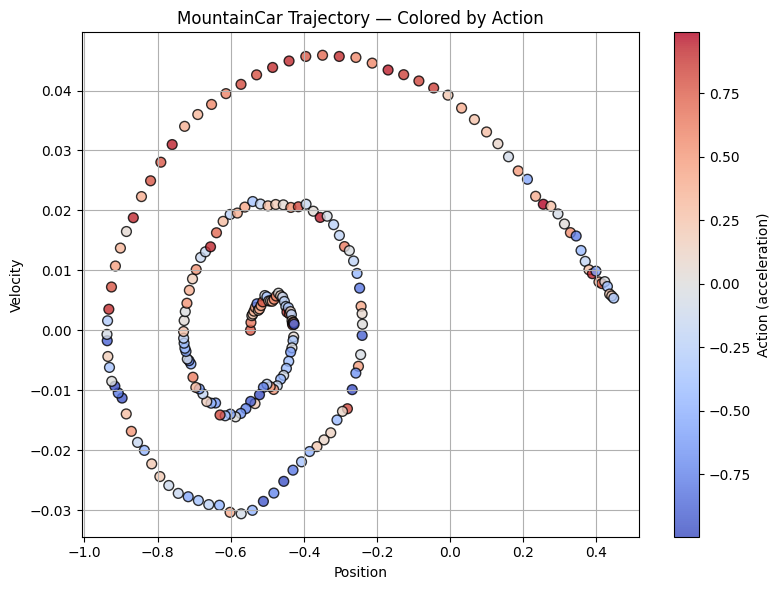

In [308]:
# trajectory is a list of [obs, a]
# each obs is [pos, vel]

def plot_trajectory(trajectory):
    positions, velocities, actions = [], [], []

    for entry in trajectory:
        obs, a = entry
        positions.append(obs[0])
        velocities.append(obs[1])
        actions.append(float(a))  # ensure scalar

    positions = np.array(positions)
    velocities = np.array(velocities)
    actions = np.array(actions)

    # --------------------------------------------------------------
    # Scatter plot: position vs velocity, colored by action
    # --------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(positions, velocities, c=actions,
                     cmap='coolwarm', s=50, edgecolor='k', alpha=0.8)

    cbar = plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("MountainCar Trajectory — Colored by Action")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_trajectory(trajectory)

* A short report (≈ 1 paragraph per reward) answering:

    * How did each reward affect the trajectory?

    * Which terms were most influential?

    * Did the car stop smoothly at the goal?

The rewards affected the selection of which is the best action in each case (using the updated costs for each case). I will discuss the functions next.

**Stop at goal**

cost = np.abs(target) + 45*x*np.abs(v)

The function was constructed using two different term. The first one uses the absolute value of the target, to reaching the goal minimized that term. The second term multiplies x by the absolute value of v (using a hand-tuned weight of 45). Since x changes sign during the episode, the system is encouraged to increase the velocity when x is negative (far away from the goal) and penalized velocity when close to the goal (positive x). I don't know if using non-linear functions like this is a bad idea, since I could not find any example on the class table (page 17). The car arrives the goal with a small velocity, as shown in the figure showing velocity-position.

**Energy-saving**

cost = np.abs(target)*5 + np.abs(a)

This cost also has two terms. The first one is the same as the previous case, so the car is encouraged to reach the target. The second term penalized the action size (less acceleration). The fallback of this implementation is that the car need more actions to reach the goal, so I can not clearly state that this cost function uses less energy (less energy per action, but more actions needed). Since the actions are small, the car also reaches the goal with a small velocity.